Para la Clorofila 

In [5]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [6]:
import rasterio
import rasterio.plot as rioplot

In [7]:
import datetime
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

In [8]:
datos_ruta = Path("~/shared/proyecto5")

In [9]:
ecoregiones_gdf = gpd.read_file(datos_ruta / "MEOW" / "meow_ecos.shp")

Seleccionamos la ecoregio

In [10]:
def seleccion_ecoregion(gdf, ecoregion):
    sel_gdf = gdf[gdf["ECOREGION"] == ecoregion]
    sel_bordes_df = sel_gdf.geometry.bounds
    sel_bordes = dict(
        minx=sel_bordes_df.minx.values[0],
        maxx=sel_bordes_df.maxx.values[0],
        miny=sel_bordes_df.miny.values[0],
        maxy=sel_bordes_df.maxy.values[0],
    )
    return sel_gdf, sel_bordes

In [11]:
ecoregion_gdf, ecoregion_bordes = seleccion_ecoregion(ecoregiones_gdf, "Central Chile")

ecoregion_bordes

Leer los datos ERDDAP, es importante que los el archivo https:/ este dentro de los rangos de Lat Lon, 
cuando se cargan datos fuera del rango mencionado no marca un error por eso no puedes darte cuenta, 
pero al final cuando quieres hacer el mapa es cuando aparece el error 

In [42]:
erddap_opendap_url = 'https://coastwatch.pfeg.noaa.gov/erddap/es/griddap/erdMH1chlamday_R2022SQ'

fuente_ds = xr.open_dataset(erddap_opendap_url)

In [43]:
fuente_ds

<xarray.Dataset>
Dimensions:    (time: 245, latitude: 4320, longitude: 8640)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-16 2002-08-16 ... 2022-11-16
  * latitude   (latitude) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    chlor_a    (time, latitude, longitude) float32 ...
Attributes: (12/52)
    _lastModified:                     2023-01-31T21:02:35.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-11-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

In [44]:
print(f"Tamaño del dataset: {fuente_ds.nbytes/1e6} MB")

Tamaño del dataset: 36578.3578 MB


In [45]:
año_inicio = 2014
año_final= 2015

In [46]:
subset_fuente_ds = fuente_ds.sel(
    time=slice(datetime.datetime(año_inicio,1,1), datetime.datetime(año_final,12,31)), 
    latitude=slice(ecoregion_bordes['maxy'], ecoregion_bordes['miny']),
    longitude=slice(ecoregion_bordes['minx'], ecoregion_bordes['maxx'])
)

In [47]:
subset_fuente_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 198, longitude: 193)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16 2014-02-16 ... 2015-12-16
  * latitude   (latitude) float32 -25.06 -25.1 -25.15 ... -33.19 -33.23 -33.27
  * longitude  (longitude) float32 -75.1 -75.06 -75.02 ... -67.19 -67.15 -67.1
Data variables:
    chlor_a    (time, latitude, longitude) float32 ...
Attributes: (12/52)
    _lastModified:                     2023-01-31T21:02:35.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-11-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

In [48]:
print(f"Tamaño del dataset: {subset_fuente_ds.nbytes/1e6} MB")

Tamaño del dataset: 3.6703 MB


In [49]:
%%time
subset_fuente_ds.load();

CPU times: user 52.3 ms, sys: 36.2 ms, total: 88.5 ms
Wall time: 4min 2s


Exploramos los datos

In [50]:
subset_fuente_ds

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 198, longitude: 193)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16 2014-02-16 ... 2015-12-16
  * latitude   (latitude) float32 -25.06 -25.1 -25.15 ... -33.19 -33.23 -33.27
  * longitude  (longitude) float32 -75.1 -75.06 -75.02 ... -67.19 -67.15 -67.1
Data variables:
    chlor_a    (time, latitude, longitude) float32 0.2258 0.2237 ... nan nan
Attributes: (12/52)
    _lastModified:                     2023-01-31T21:02:35.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:                 2022-11-16T00:00:00Z
    time_coverage_start:               2002-07-16T00:00:00Z
    title:                             Chlorophyll-a, Aqua MODIS, NPP, L3SMI,...
    Westernmost_Easting:               -179.9792

Para corregir la visualización de los mapas, intente coonvertir el xarray del subgrupo en log10

In [22]:
import numpy as np

In [52]:
subset_fuente_ds["chlor_a"]=np.log10(subset_fuente_ds.chlor_a)

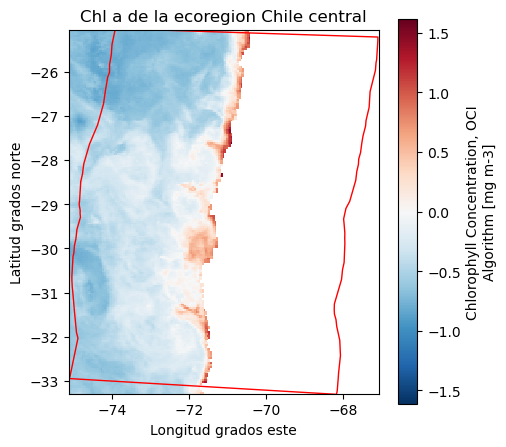

In [59]:
_, ax = plt.subplots(ncols=1, figsize=(5,5))
subset_fuente_ds.chlor_a.isel(time=0).plot(ax=ax)
ecoregion_gdf.plot(ax=ax, edgecolor='red', facecolor='none');
plt.title('Chl a de la ecoregion Chile central')
plt.xlabel('Longitud grados este')
plt.ylabel('Latitud grados norte')
ax.set = 
min, max = ((0), (1.5))

El mapa si capbia bastante, pero si vemos en la barra de escala aparecen valores negativos, lo que no es correcto
entonces el siguiente paso es proponer un valor maximo y un valor minimo para nuestra submuestra xarray
en este caso podria ser del 0.0 al 1.5, pero tampoco son valores muy reales de acuerdo a nuestra serie de tiempo que se muestra abajo

In [42]:
chla_xypromedio_df = subset_fuente_ds.chlor_a.mean(dim=('latitude', 'longitude'))

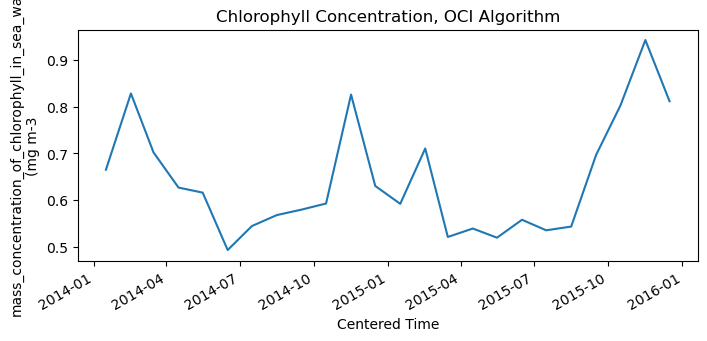

In [43]:
da = subset_fuente_ds.chlor_a

sst_xypromedio_df.plot(figsize=(8,3))
plt.ylabel(f"{da.standard_name}\n({da.units}")
plt.title(da.long_name);